# III.3 Spatial Aggregation

One powerful technique in spatial analysis is **spatial aggregation** — summarizing data based on geographic units.  
This helps us move from individual features (like points or lines) to broader patterns and trends.

A common use case is analyzing the **density of point features** — such as cafés, crime incidents, or public facilities — across a city or region.  
To do this, we often create a **regular grid** (also known as a **fishnet**) that covers the area of interest and then count how many points fall within each grid cell.

This regular grid allows for:

- Uniform spatial comparison across the entire area
- Easy visualization of patterns and clusters
- Compatibility with heatmaps or raster-like outputs

This method provides a **visual and quantitative understanding** of how features are distributed in space. It helps to:

- Identify hotspots or areas with low activity
- Compare different parts of the city based on feature concentration
- Support decision-making in urban planning, public services, and resource allocation

In addition to using a uniform grid, you can also aggregate points by **existing administrative boundaries** — such as districts or neighborhoods — using a **spatial join** followed by a `groupby`.

Spatial aggregation turns raw geographic data into structured insights that are easier to analyze and communicate.


## Creating a Grid


To build a grid, we need two things: the **boundary of the area** we’re interested in and a **cell size**.  
For example, let’s use the boundary of one of the districts in Saint Petersburg and set the grid cell size to 200 meters.

We’ll write a simple algorithm that takes the **extent (bounding box)** of the selected area and the desired **cell size**, and generates a `GeoDataFrame` containing a polygon-based grid (fishnet) that fully covers the area.


### Step 0 – Load the Boundary Data


In [ ]:
#Запишем в переменную название изучаемого района 
area = "Центральный район, Санкт-Петербург"

# Получаем границу района с помощью номинального геокодирования
admin_polygon = ox.geocode_to_gdf(area)
print("Исходная CRS:", admin_polygon.crs)


Исходная CRS: epsg:4326


If the dataset is in geographic coordinates, reproject it to UTM


### Step 1 – Reproject the data to a metric coordinate syste


In [ ]:
# Определяем и устанавливаем UTM-проекцию
utm_zone = admin_polygon.estimate_utm_crs()
admin_polygon = admin_polygon.to_crs(utm_zone)
print("Проекция для сетки:", admin_polygon.crs)

Проекция для сетки: EPSG:32636


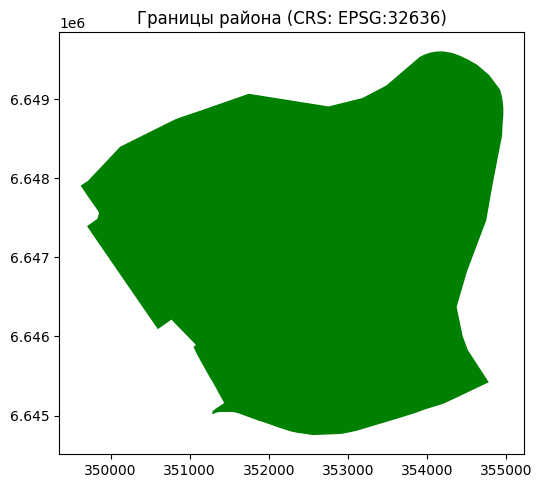

In [ ]:
# Визуализация
ax = admin_polygon.plot(marker='o', color='green', figsize=(6,6))
plt.title("Границы района (CRS: {})".format(utm_crs))
plt.show()

### Step 2 – Define the extent (bounding box)


Let’s define the boundaries of the area for generating the grid.


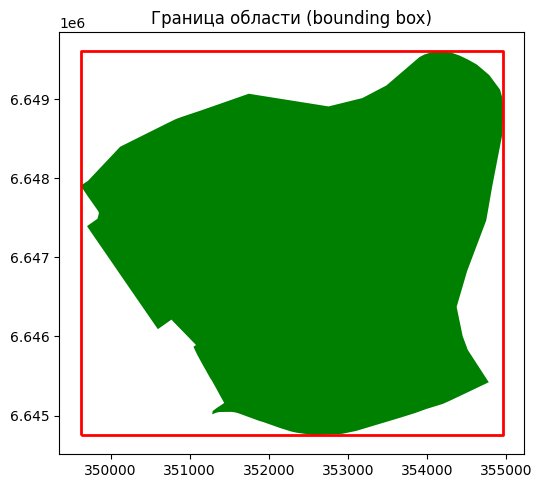

In [ ]:
# Определяем минимальные и максимальные значения координат по долготе и по широте
minx, miny, maxx, maxy = admin_polygon.total_bounds

# Строим полигон-рамку (для визуалиации того, что мы получили - не обязательный шаг непосредственно для пострения сетки)
bbox = Polygon([
    (minx, miny), (maxx, miny),
    (maxx, maxy), (minx, maxy)
])

# Посмотрим на результат
ax = admin_polygon.plot(marker='o', color='green', figsize=(6,6))
gpd.GeoSeries([bbox], crs=utm_crs).plot(
    ax=ax, facecolor='none', edgecolor='red', linewidth=2
)
plt.title("Граница области (bounding box)")
plt.show()

### Step 3 – Define the cell size


In [ ]:
# Параметр: размер ячейки (в метрах)
square_size = 500

### Step 4 – Generate grid cells within the specified boundary polygon


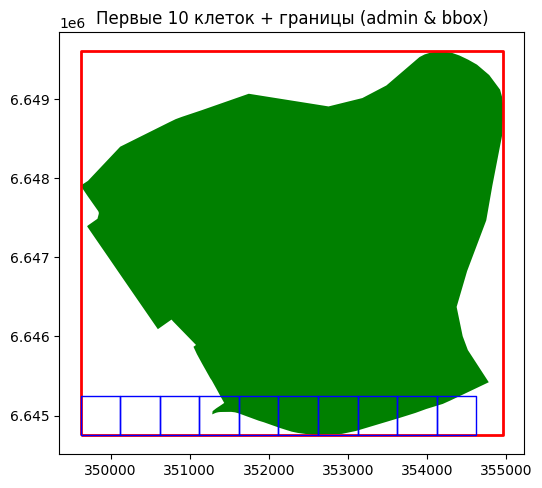

In [ ]:
# Список будущих полигонов
grid_cells = []

# Стартовые координаты
x0, y0 = minx, miny
x, y = x0, y0

# Проходим по строкам и столбцам
while y <= maxy:
    while x <= maxx:
        grid_cells.append(
            box(x, y, x + square_size, y + square_size)
        )
        x += square_size
    # после строки: сброс по X и шаг по Y
    x = x0
    y += square_size


# Отфильтруем первые 10 ячеек, чтобы на них посмотреть 
first_few = grid_cells[:10]
ax = gpd.GeoSeries(first_few, crs=utm_crs).plot(
    figsize=(6,6), edgecolor='blue', facecolor='none', zorder=3
)

# отобразим также границу района
admin_polygon.plot(ax=ax, marker='o', color='green', linewidth=1)

# и его экстент
gpd.GeoSeries([bbox], crs=utm_crs).plot(
    ax=ax, facecolor='none', edgecolor='red', linewidth=2
)


plt.title("Первые 10 клеток + границы (admin & bbox)")
plt.show()

### Step 5 – Assemble the final grid into a GeoDataFrame


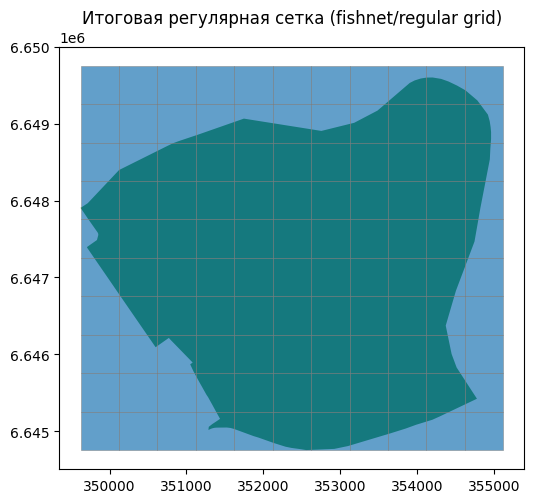

In [ ]:
# Собираем всё в GeoDataFrame
fishnet = gpd.GeoDataFrame({'geometry': grid_cells}, crs=utm_crs)

# Показываем итоговую сетку поверх данных
ax = admin_polygon.plot(marker='o', color='green', figsize=(6,6))
fishnet.plot(ax=ax, edgecolor='gray', linewidth=0.5, alpha=0.7)
plt.title("Итоговая регулярная сетка (fishnet/regular grid)")
plt.show()

### Step 6 – Write a function based on the algorithm


Based on our algorithm, let’s write a function that takes just two inputs:  
the source data (to determine the extent) and the desired grid cell size.


In [ ]:
from shapely.geometry import Polygon

def create_regular_grid(gdf, square_size):
    # Если набор в географических координатах, перепроецируем в UTM
    utm_crs = gdf.estimate_utm_crs()
    gdf_utm = gdf.to_crs(utm_crs)
    # Получаем границы (bounding box) области
    minX, minY, maxX, maxY = gdf_utm.total_bounds
    grid_cells = []
    x, y = minX, minY
    # Двойной цикл: заполняем прямоугольник границ квадратами заданного размера
    while y <= maxY:
        while x <= maxX:
            grid_cells.append(box(x, y, x + square_size, y + square_size))
            x += square_size # двигаемся по X
        x = minX             # возврат к началу по X
        y += square_size     # двигаемся по Y (следующий ряд)
    # Формируем GeoDataFrame
    fishnet = gpd.GeoDataFrame(geometry=grid_cells, crs=utm_crs)
    return fishnet



In [ ]:
# Строим сетку с шагом 200 м
fishnet = create_regular_grid(admin_polygon, square_size=200)
print(f"Создано ячеек: {len(fishnet)}")
fishnet.head(3)

Создано ячеек: 675


,geometry
0,"POLYGON ((349822.326 6644753.924, 349822.326 6..."
1,"POLYGON ((350022.326 6644753.924, 350022.326 6..."
2,"POLYGON ((350222.326 6644753.924, 350222.326 6..."


Let’s take a look at the grid on the map.


In [ ]:
fishnet.explore(tiles='CartoDB positron')

## Data aggregation - Point Count

Теперь получим данные о расположении **кафе** в исследуемом районе. Используем OSMnx для выгрузки точек с тегом `amenity=cafe` в границах района. Затем с помощью spatial join определим, сколько кафе попадает в каждую ячейку сетки.


### Step 1: Download and process the required data from OSM


In [ ]:
# Выгружаем из OpenStreetMap объекты с тегом "amenity=cafe" в пределах района
tags = {"amenity": "cafe"}
cafes = ox.features_from_place(area, tags)


In [ ]:
# Преобразуем полученные объекты в точки (некоторые кафе могут быть полигонами зданий)
cafes_points = gpd.GeoDataFrame(cafes.geometry.centroid, columns=['geometry'], crs=cafes.crs)
print(f"Всего объектов 'cafe': {len(cafes_points)}")

Всего объектов 'cafe': 808


/var/folders/ry/9bb7wrz54vq_kn2ytlj6ynzm0000gn/T/ipykernel_43255/3251615081.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cafes_points = gpd.GeoDataFrame(cafes.geometry.centroid, columns=['geometry'], crs=cafes.crs)


In [ ]:
# Приводим точки кафе к той же проекции, что и сетка (UTM)
cafes_points_utm = cafes_points.to_crs(fishnet.crs)

### Step 2 – Perform a Spatial Join


We intersect the café points with the polygons of the regular grid


In [ ]:
# sjoin: определяем, в какой квадрат попадает каждое кафе
cafes_in_grid = gpd.sjoin(cafes_points_utm, fishnet, predicate="within", how="left")

cafes_in_grid.head()


geometry  index_right
element id                                                    
node    444776758    POINT (352699.493 6646602.8)          258
        446064734  POINT (351678.463 6645258.762)           64
        446064736   POINT (351650.506 6645295.67)           64
        652383850  POINT (350611.376 6647347.884)          328
        654105840  POINT (352843.747 6646584.659)          259

Count the number of points that fall within each polygon


In [ ]:
# Подсчитываем число точек в каждой ячейке (группируем по индексу ячейки)
cafes_count_per_cell = cafes_in_grid.groupby('index_right').size()

cafes_count_per_cell.head()

index_right
12    1
13    1
38    1
45    1
46    1
dtype: int64

Store the results in the original grid layer


In [ ]:
# Добавляем столбец с количеством кафе в соответствующую ячейку сетки
fishnet['cafes_count'] = cafes_count_per_cell
fishnet['cafes_count'] = fishnet['cafes_count'].fillna(0).astype(int)  # заполняем 0, где кафе нет
fishnet.head(3)

,geometry,cafes_count
0,"POLYGON ((349822.326 6644753.924, 349822.326 6...",0
1,"POLYGON ((350022.326 6644753.924, 350022.326 6...",0
2,"POLYGON ((350222.326 6644753.924, 350222.326 6...",0


Let’s take a look at the result.


In [ ]:
fishnet.explore(column='cafes_count', cmap='YlGnBu', tiles='CartoDB positron')

### Step 3 – Calculate the density of features


We’ve added the number of cafés in each grid cell as `cafes_count`.  
Now let’s calculate the **café density** — the number of cafés per square kilometer in each cell.


In [ ]:
# Вычисляем площадь каждой ячейки в квадратных метрах
cell_area_m2 = fishnet.geometry.area  
# Добавляем столбец плотности кафе (число кафе на 1 км²)
fishnet['cafe_density'] = fishnet['cafes_count'] / (cell_area_m2 / 1_000_000)

fishnet.head()


,geometry,cafes_count,cafe_density
0,"POLYGON ((349822.326 6644753.924, 349822.326 6...",0,0.0
1,"POLYGON ((350022.326 6644753.924, 350022.326 6...",0,0.0
2,"POLYGON ((350222.326 6644753.924, 350222.326 6...",0,0.0
3,"POLYGON ((350422.326 6644753.924, 350422.326 6...",0,0.0
4,"POLYGON ((350622.326 6644753.924, 350622.326 6...",0,0.0


We’ll assign a color to each grid cell based on its café density:


In [ ]:
fishnet.explore(column='cafe_density', cmap='YlGnBu', scheme='NaturalBreaks', legend=True,
legend_kwds={'caption': 'Кафе на км²'}, tiles='CartoDB positron')


## Attribute Aggregation by Spatial Units

In this step, we’re not just counting how many points fall into each polygon —  
we’re **aggregating the attributes of those points** within spatial units such as grid cells or administrative areas.

This type of aggregation is useful when:

- You want to calculate the **average**, **sum**, or **max/min** of a numerical field (e.g., café rating, capacity, number of employees)
- You need to analyze **thematic data** by location, not just spatial distribution
- You're preparing values for **choropleth maps** or **statistical summaries** tied to specific areas

### Workflow:

1. Perform a **spatial join** to assign each point to its corresponding polygon or grid cell
2. Use **`groupby()`** on the polygon ID and apply aggregation functions (e.g. `.mean()`, `.sum()`, `.max()`)

This approach combines **spatial relationships** with **attribute-level insights**, making it


In [ ]:
#Данные с округами в Санкт-Петербурге в формате geopackage
admin_okrug = gpd.read_file('data/spb_admin.gpkg', layer="okrug")

#МКД Санкт-Петербурга в формате csv
mkd = pd.read_csv('data/spb_mkd.csv')
#Разбиваем поле с координатами на два - 'lat' -- широта; 'lon' -- долгота
mkd[['lat', 'lon']] = mkd['coordinates'].str.split(',', expand=True).astype(float)
#На основе DataFrame создаем GeoDataFrame, определяя геометрию на основе координат
mkd_gdf = gpd.GeoDataFrame(mkd, geometry=gpd.points_from_xy(mkd['lon'], mkd['lat']), crs=4326)

Давайте посмотрим, какая атрибутивная информация есть в слое с МКД


In [ ]:
# такая запись помогает нам не просто показать первые строки, но и транспонировать таблицу, чтобы увидеть сразу все столбцы
mkd_gdf.head().T

У нас, к сожалению, нет документации с описанием названий полей, но мы +- можем догадываться, какая именно информация содержится в полях.

Из интересной информации, которую бы мы хотели посмотреть по каждому из округов можно выбрать:
data_buildingdate - год постройки;

**Давайте для каждого района посчитаем средний, медианный, самый ранний и самый поздний год постройки МКД**


Первые шаги будут аналогичны тем, которые мы выполняли на прошлой неделе при подсчете кол-ва точек по ячейкам регулярной сетки


### Step 1 – Perform a Spatial Join

We intersect the café points with the polygons of the regular grid  
(_make sure both layers are in the same coordinate reference system_).


In [ ]:
# sjoin: определяем, в какой округ попадает каждый из МКД
mkd_in_okrug = gpd.sjoin(mkd_gdf, admin_okrug, predicate="within", how="left")

mkd_in_okrug.head()

In the attribute table above, all fields that appear after `"geometry"` come from the district layer.  
They were added based on which district each point falls into during the spatial join.


##### Step 2 – Calculate Statistics

We group the data based on which district each point falls into (for example, using the `index_right` field) and calculate the desired values.

**Important:** Since we're calculating **quantitative statistics**, we need to make sure that the fields we're using (like `data_buildingdate` or `data_residents`) are of a **numeric type**.  
If they’re not, we should convert them to numbers before aggregating.


In [ ]:
# 1. Посмотреть исходные типы
print("До преобразования:")
print(mkd_in_okrug[['data_buildingdate']].dtypes)

# 2. Преобразование

mkd_in_okrug['data_buildingdate'] = pd.to_numeric(mkd_in_okrug['data_buildingdate'], errors='coerce')

# 3. Проверка — типы после
print("\nПосле преобразования:")
print(mkd_in_okrug['data_buildingdate'].dtypes)


Great! Now we can confidently calculate quantitative statistics based on this field.


Рассчитаем средний год постройки МКД в разных округах


In [ ]:
build_year_mean = mkd_in_okrug.groupby('index_right')['data_buildingdate'].mean()

# Добавляем в данные поля с средним годом постройки в слой с округами
admin_okrug['build_year_mean'] = build_year_mean

# Смотрим на результат
admin_okrug.explore(column='build_year_mean', cmap='YlGnBu', tiles='CartoDB positron')



Выглядит очень интересно и правдоподобно :)


По аналогии посчитаем медианный год постройки, а также самый ранний и самый поздний


In [ ]:
build_year_median = mkd_in_okrug.groupby('index_right')['data_buildingdate'].median()
build_year_min = mkd_in_okrug.groupby('index_right')['data_buildingdate'].min()
build_year_max = mkd_in_okrug.groupby('index_right')['data_buildingdate'].max()

# Добавляем в данные соответсвующие поля
admin_okrug['build_year_median'] = build_year_median
admin_okrug['build_year_min'] = build_year_min
admin_okrug['build_year_max'] = build_year_max



Отобразим 4 показателя вместе для сравнения


In [ ]:
metrics = [
    ('build_year_mean', 'Средний год постройки'),
    ('build_year_median', 'Медианный год постройки'),
    ('build_year_min', 'Самый ранний год постройки'),
    ('build_year_max', 'Самый поздний год постройки'),
]

# Общий диапазон для всех карт
vmin = admin_okrug[[m for m, _ in metrics]].min().min()
vmax = admin_okrug[[m for m, _ in metrics]].max().max()

# Создаём одну фигуру с 1 строкой и 4 столбцами
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)

# Создаём общий нормализатор и мэппер для цветовой шкалы
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = mpl.cm.viridis  # или любая другая

for ax, (metric, title) in zip(axes, metrics):
    admin_okrug.plot(
        column=metric,
        ax=ax,
        cmap=cmap,
        norm=norm,
        linewidth=0.5,
        edgecolor='gray'
    )
    ax.set_title(title, fontsize=12)
    ax.axis('off')

# Общая colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # пустой массив, чтобы colorbar работал
cbar = fig.colorbar(sm, ax=axes.tolist(), orientation='horizontal',
                    fraction=0.05, pad=0.02)
cbar.set_label('Год постройки', fontsize=12)

plt.show()

## Summary
